In [1]:
def get_player_id(x):
    '''Input Players Webname and return the player ID, full name and team'''
    return(merge_.loc[merge_['web_name'].str.contains(x,flags=re.IGNORECASE)][['element','web_name','first_name','team','name']].drop_duplicates(subset='element'))

In [4]:
import requests
import pprint
import os
import pandas as pd
import re
import numpy as np
import time
import datetime
import matplotlib.pyplot as plt
import manager_info

%matplotlib inline

# URLs for FPL 
------------------

In [ ]:
TOP_LEVEL_PLAYER_INFO = 'https://fantasy.premierleague.com/api/bootstrap-static/'

GAMEWEEK_SUMMARY_BY_PLAYER = f'https://fantasy.premierleague.com/api/element-summary/1/'

MANAGER_TEAM_INFO_BY_GAMEWEEK = 'https://draft.premierleague.com/api/entry/xxxx/event/1'

# Access Top Level Player and Team Information Including Names And Top Level Stats
------------------

In [ ]:
# For teams and players

getJson = requests.get(TOP_LEVEL_INFO).json()

teams = pd.DataFrame.from_dict(getJson['teams'])

playerInfo = pd.DataFrame.from_dict(getJson['elements'])
playerInfo['element_id'] = playerInfo['id'].copy()

# Access Detailed Player Information Gameweek By Gameweek

URL = f'https://fantasy.premierleague.com/api/element-summary/{i}/'

------------------

In [ ]:
combinedOutput = pd.DataFrame()
for i in np.arange(1,665):
    URL = f'https://fantasy.premierleague.com/api/element-summary/{i}/'
    
    # PLayer Detail Request
    a = requests.get(URL)
    # Convert Player Detail Request To JSON
    b = a.json()
    # Convert the JSON key history to Dataframe
    c = pd.DataFrame.from_dict(b['history'])
    # Combine the output
    combinedOutput = pd.concat([combinedOutput,c],axis=0,ignore_index=True)
    time.sleep(0.25)
    
combinedOutput.to_csv('element_summary/element_profile_data_by_gameweek.csv')

# Access Manager's Team Information In A League Gameweek By Gameweek

https://draft.premierleague.com/api/entry/404104/event/9 

KEYS = 'picks', 'entry_history', 'subs'

Event parameter in url starts at 1

Manager Name, Manager ID And Gameweek (event) assigned manually to each dataframe 

------------------

In [ ]:
# We are interested in two keys from the request
jsonKeys = ['picks','subs']

# maxGameweek is used to access the most recent batch of data which includes historical data (gameweek 1 - e.g. 18)
maxGameweek = input('Input the most recent gameweek here (int)')

# Be sure the maxGameweek input is an int
maxGameweek = int(maxGameweek)

# access list of manager names and manager ids
managerID = manager_info.managerID

for i in jsonKeys:
    
    for j in managerID:

        # j[0] == managerID
        # j[1] == managerName
        # maxGameweek == gameweeks played to date

        # New dataframe for each manager
        combinedOutput = pd.DataFrame()

        # Loop through each gameweek up to max
        for k in np.arange(1,maxGameweek):

            # request data from each manager id and each gameweek (event/round)
            output = pd.DataFrame.from_dict(requests.get(f'https://draft.premierleague.com/api/entry/{j[0]}/event/{k}').json()[i])

            # sleep 
            time.sleep(0.25)

            # store manager id in dataframe
            output['managerId'] = j[0]

            # store manager name in dataframe
            output['managerName'] = j[1]

            # store gameweek each request
            output['event'] = k
            
            # store key
            output['key'] = i

            # combine requests into a single dataframe per manger
            combinedOutput = pd.concat([combinedOutput,output],axis=0,ignore_index=True)

        # Save csvs using manager name and using max gameweek for freshness    
        combinedOutput.to_csv(f'manager_player_gameweeks/{j[1]}_max_gw_{maxGameweek}_{i}.csv')  

# Join All The Data Together
------------------

In [ ]:
import glob

#create list of csv files in directory that contain 'picks' and the gameweek in the file name
csv_files = glob.glob(f'manager_player_gameweeks/*{maxGameweek}_picks.csv')

#create empty list to hold the dataframes
df_list = []

#loop through csv files and append to df_list
for filename in csv_files:
    df_list.append(pd.read_csv(filename,index_col=0))

#concatenate all dataframes in df_list vertically
managerPlayersGameweek = pd.concat(df_list, ignore_index=True)

#### Recoding Needed For Akanji

 1. 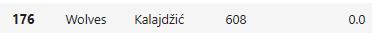

 2. 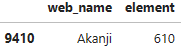

In [ ]:
managerPlayersGameweek['element'].replace(608,610,inplace=True)

# Link Manager's Info With Gameweek Stats, Player Info, Team's Info
------------------

In [ ]:
# Merge Manager's with gameweek by gameweek stats 
elementGameweekStats = pd.read_csv('element_summary/element_profile_data_by_gameweek.csv',index_col=0)
merge_ = pd.merge(managerPlayersGameweek, elementGameweekStats, left_on = ['event','element'], right_on = ['round','element'], suffixes=('_MGW','_EGS')) 

# Merge Manager's with Player Info
merge_ = pd.merge(merge_, playerInfo, left_on ='element', right_on ='id',suffixes=('','_PI'))

# Player's Team Info Added
merge_ = pd.merge(merge_,teams[['name','id']],left_on='team',right_on='id',suffixes=('','_T'))

# Player's Opponent Team Info Added
merge_ = pd.merge(merge_,teams[['name','id']],left_on='opponent_team',right_on='id',suffixes=('','_OppT'))

# Tag Player's who contributed points each week for real league totals
merge_['total_points_1_11'] = merge_.loc[merge_['position'].between(1,11,inclusive='both')]['total_points'].copy()
merge_['total_points_1_11'].fillna(0,inplace=True)

# New Datasource 'gameweekRanking': Create A League Ranking For Tableau Viz
------------------

In [ ]:
gameweekRanking = merge_.groupby(['event','managerName'])['total_points_1_11'].sum().reset_index(name='totalPoints(1-11)')
gameweekRanking['total_points(1-11)_cumsum'] =  gameweekRanking.groupby(['managerName'])['totalPoints(1-11)'].cumsum()
gameweekRanking['gameweekRank'] = gameweekRanking.groupby(['event'])['totalPoints(1-11)'].rank(method='dense',ascending=False)
gameweekRanking['leagueRank'] = gameweekRanking.groupby(['event'])['total_points(1-11)_cumsum'].rank(method='dense',ascending=False)


# Create a first gameweek fixed tag for each manager
-------------------

In [ ]:
elementGameweekStats['first_gw_mamager'] = np.nan
elementGameweekStats.loc[elementGameweekStats['element'].isin(manager_info.dev_first_team_id),'first_gw_mamager'] = 'Dev'
elementGameweekStats.loc[elementGameweekStats['element'].isin(manager_info.luke_first_team_id),'first_gw_mamager'] = 'Luke'
elementGameweekStats.loc[elementGameweekStats['element'].isin(manager_info.harry_first_team_id),'first_gw_mamager'] = 'Harry'
elementGameweekStats.loc[elementGameweekStats['element'].isin(manager_info.mick_first_team_id),'first_gw_mamager'] = 'Mick'
elementGameweekStats.loc[elementGameweekStats['element'].isin(manager_info.sam_first_team_id),'first_gw_mamager'] = 'Sam'
elementGameweekStats.loc[elementGameweekStats['element'].isin(manager_info.cameron_first_team_id),'first_gw_mamager'] = 'Cameron'
merge_elementsFristGameweek = elementGameweekStats[elementGameweekStats['first_gw_mamager'].notnull()]


# Generate Outputs For Viz
-----------------------

In [ ]:
now = datetime.datetime.now()
current_date = now.strftime("%Y-%m-%d")

# pipeline to tableau
merge_.to_csv('final_merge/fantasy_league_data_mr.csv')

# record saved by date
merge_.to_csv(f'final_merge/fantasy_league_data_({current_date}).csv')

gameweekRanking.to_csv('final_merge/gameweek_league_Ranking_mr.csv')

gameweekRanking.to_csv(f'final_merge/gameweek_league_Ranking_({current_date}).csv')

merge_elementsFristGameweek.to_csv(f'final_merge/elementsFristGameweek_mr.csv')